# Song Genre Classification with Audio Data

Examining data compiled by - The Echo Nest. 

The goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. 

In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through machine learning algorithms, such as decision trees and logistic regression.

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
os.getcwd()

'C:\\Users\\srish\\01.Projects'

In [3]:
os.chdir("C:\\Users\\srish\\Desktop\\EverythingDS")

In [4]:
# Read in track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
# Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json',precise_float = True)

In [9]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [8]:
print('tracks data:',tracks.shape)

tracks data: (17734, 21)


In [10]:
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [11]:
print('metric data:',echonest_metrics.shape)

metric data: (13129, 9)


In [12]:
# Merge the track_id and genre_top columns of tracks and echonest_metrics on track_id values
echo_tracks = pd.merge(left = tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')

echo_tracks.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [13]:
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
genre_top           4802 non-null object
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


##### Checking for multicollinearity

Multicollinearity increases the standard errors of the coefficients.  

In other words, by overinflating the standard errors, multicollinearity makes some variables statistically insignificant when they should be significant. 

Without multicollinearity (and thus, with lower standard errors), those coefficients might be significant.

In [14]:
# Creating a correlation matrix to see to check if multicollinearity exists
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


Here we can see an interesting correlation between danceability and valence, but it's not strong enough for us to drop a feature

##### Scaling and PCA

To get the best results from our model it is best to use the limit the features to the necessary ones. Which can be achieved by a dimension reduction procedure - PCA (Principal Component Analysis)

But the way in which PCA works is that it rotates our data around the axis of highest variability so we can determine how much of it is explained by our other independent variables. 

However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features.

To avoid this we normalise the range of our data by using scaling techniques.

In [16]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

##### PCA

We can use scree-plots to find the number of components to use in further analyses.

Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.

In [17]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
exp_variance

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

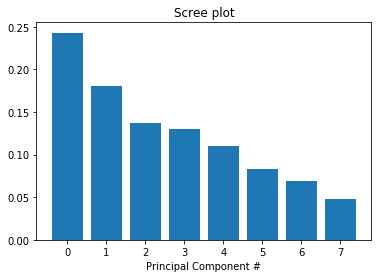

In [29]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
ax.set_title('Scree plot')
plt.show()

There does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

Instead, we can also look at the cumulative explained variance plot to determine how many features are required to explain, say, about 90% of the variance.

Once we determine the appropriate number of components, we can perform PCA with that many components.

In [28]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

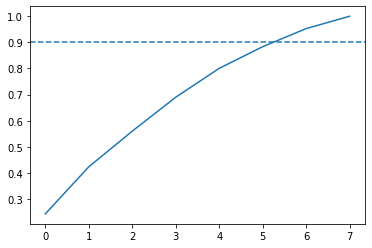

In [32]:
# plotting cumulative explained variance and the threshold at 0.9
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [126]:
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [127]:
pca_projection.shape

(4802, 7)

##### Modelling

In [110]:
# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, stratify = labels)

In [111]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [112]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels_tree)

0.7912087912087912

In [113]:
labels.value_counts()

Rock       910
Hip-Hop    910
Name: genre_top, dtype: int64

In [114]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels_tree)

array([[182,  46],
       [ 49, 178]], dtype=int64)

Seems like our data is highly imbalanced so our accuracy metric isn't significant as to how our classifier is actually performing.

Before we balance our data let's check how Logistic Regression performs on the imbalanced data

In [115]:
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

In [116]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.80      0.79       228
        Rock       0.79      0.78      0.79       227

    accuracy                           0.79       455
   macro avg       0.79      0.79      0.79       455
weighted avg       0.79      0.79      0.79       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.89      0.79      0.84       228
        Rock       0.81      0.90      0.85       227

    accuracy                           0.84       455
   macro avg       0.85      0.84      0.84       455
weighted avg       0.85      0.84      0.84       455



Looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

We see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

In [117]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

In [118]:
rock_only.shape, hop_only.shape

((3892, 10), (910, 10))

Since we cant possibly create more data at this point to outweigh the imbalance, it is a goo idea to undersample our rock only data frame

In [119]:
rock_only = rock_only.sample(n= hop_only.shape[0])
rock_only.shape, hop_only.shape

((910, 10), (910, 10))

In [120]:
rock_hop_bal = pd.concat([rock_only, hop_only])
rock_hop_bal.shape

(1820, 10)

In [121]:
# features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,
                                                                            labels,
                                                                            stratify = labels,
                                                                            random_state=10)

We've removed a lot of data points that might have been crucial to training our models. 

Let's test to see if balancing our data improved the model bias towards the "Rock" classification while retaining overall  performance of classification.

In [122]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

#classification report
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.77      0.79       227
        Rock       0.78      0.82      0.80       228

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.81      0.81       227
        Rock       0.81      0.82      0.81       228

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       455
weighted avg       0.81      0.81      0.81       455



We seem to have attained a better classifiaction accuracy. 

Now using cross validation for a more rigorous model comparision should help us boost the results. (Here we shall be using K fold CV)

In [125]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv = kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),
      "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.773076923076923 Logistic Regression: 0.8120879120879121


We can see here that our simple Logistic Regression model performed better than the Decision tree model on the balanced data. 